# Warning
This notebook is under development- please use to evaluate entropy notebook and suggest desired changes only.

# Entropy cut files for ML

## Import libraries

In [1]:
%matplotlib widget
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
import collections
from collections import namedtuple
import builtins
import math
# IMPORT Ole's fixed TMSiSDK python interfacwe- may change
sys.path.insert(0,'C:/Projects/tmsi-python-interface')
from TMSiSDK.file_readers import Poly5Reader
# import our library
sys.path.insert(0, '../resurfemg')
import helper_functions as hf



C:\Users\makeda\anaconda3\envs\emgandash\lib\site-packages\mne\fixes.py:321: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(scipy.__version__) >= '1.1':
C:\Users\makeda\anaconda3\envs\emgandash\lib\site-packages\mne\fixes.py:1134: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(numba.__version__) < LooseVersion('0.40'):
C:\Users\makeda\anaconda3\envs\emgandash\lib\site-packages\mne\fixes.py:1134: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(numba.__version__) < LooseVersion('0.40'):


# Set a collection place for experiments

In [2]:
# do not rerun this cell
big_data_list= []

Below change the path to the root directory where you are keeping your EMGs and ventilator "Draeger" files

# Reruns should be done from this cell as the start

In [3]:
root_emg_directory = os.path.join('../not_pushed','topspin_data_anonymized')

In [4]:
emg_pattern = os.path.join(root_emg_directory, '**/*.Poly5')
emg_and_draeger_files = glob.glob(emg_pattern, recursive=True)

emg_files = []
draeger_files = []

for file in emg_and_draeger_files:
    if 'Draeger' in file:
        draeger_files.append(file)
    else:
        emg_files.append(file)

Now you can pick a file from the list, which have been numbered.

In [5]:
list_of_numbers_strung = []
for i in range(len(emg_files)):
    list_of_numbers_strung.append(str(i))


btn = widgets.Dropdown(
    options=list_of_numbers_strung,
    value='0',
    description='Picked File:',
    disabled=False,
)
display(btn)

Dropdown(description='Picked File:', options=('0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '1…

# Caution! 
If you folder is set up in any way different then the picked file numbers will not neccesarily correspond to the same file. Always check the print out for the file you have chosen in the cell below

In [6]:
number_chosen = int(btn.value)
file_chosen = emg_files[number_chosen] 
print("The file you chose is:",file_chosen)

The file you chose is: ../not_pushed\topspin_data_anonymized\M001\001\EMG_recording.Poly5


In [7]:
data_emg = Poly5Reader(file_chosen)
data_samples= data_emg.samples
emg_sample_rate = data_emg.sample_rate
converted_to_seconds =  []
converted_to_samples = []
for i in range(len(data_samples[0])):
    converted_to_seconds.append(i/emg_sample_rate)
    converted_to_samples.append(i)

Reading file  ../not_pushed\topspin_data_anonymized\M001\001\EMG_recording.Poly5
	 Number of samples:  172576 
	 Number of channels:  3 
	 Sample rate: 2048 Hz
Done reading data.


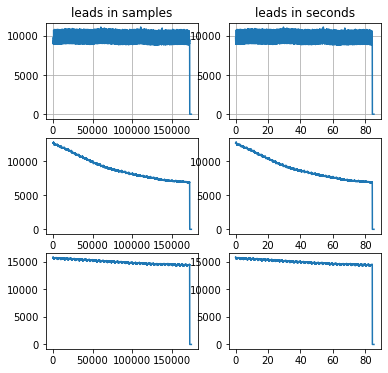

In [8]:
%matplotlib inline
# set up plotn
x = data_samples
fig, axis = plt.subplots(nrows = 3, ncols = 2, figsize=(6, 6))
#ax.set_ylim([-4, 4])
axis[0,0].grid(True)
axis[0,0].plot(x[0])
axis[0,0].set(title='leads in samples')
axis[1,0].plot(x[1])
axis[2,0].plot(x[2])
axis[0,1].set(title='leads in seconds')
axis[0,1].grid(True)
axis[0,1].plot(converted_to_seconds,x[0])
axis[1,1].plot(converted_to_seconds,x[1])
axis[2,1].plot(converted_to_seconds,x[2])

That is the whole unfiltered EMG, but you probably want to examine a part. You will also want to examine something filtered down to only the EMG components. Therefore we will filter off only the EMG components with an ICA in addtion to the filter we will play with.

Now you can filter down to which part you want to see. 

Do you want to cut and see the file in samples or seconds?

In [9]:
y_axis = widgets.Dropdown(
    options=["Samples","Seconds"],
    value='Samples',
    description="Select View Option",
    disabled=False,
)
display(y_axis)


Dropdown(description='Select View Option', options=('Samples', 'Seconds'), value='Samples')

In [10]:
time_view= y_axis.value
time_view

'Samples'

Now you will pick the start and end of your sample. In the future we will have an updating graph here. 
# NOTE - because processing chops a bit, and other distortions, you must pick at least 100 in on either side

In [11]:
if time_view == 'Samples':
    int_slider1 = widgets.IntSlider(
        min=0, max=len(x[0]), step=1,
        description=' samples start'
    )
    int_slider2 = widgets.IntSlider(
        value=len(x[0]),
        min=0, max=len(x[0]), step=1,
        description='samples end cutoff'
    )
else:
    int_slider1 = widgets.IntSlider(
        #value=0.1,
        min=0, max= converted_to_seconds[-1], step=1,
        description='seconds start'
    )
    int_slider2 = widgets.IntSlider(
        #value=converted_to_seconds[-1],
        min=0, max=converted_to_seconds[-1], step= 1,
        description='seconds end cutoff'
    )
    
widgets.VBox(
    [

        int_slider1,
        int_slider2,

    ]
)



In [ ]:
# # # Here we can overwrite the values by hand
# int_slider1.value = 100
# int_slider2.value = 170000

For now we will graph your choice in the next active cell

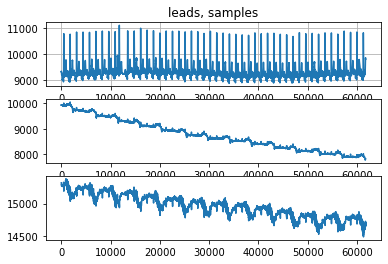

In [29]:
start = int_slider1.value
end= int_slider2.value
if time_view == 'Samples':
    # nox examine at a certain scale- from point a to b as samples
    x = data_samples
    fig, (ax_1,ax_2,ax_3) = plt.subplots(nrows = 3, figsize=(6, 4))
    ax_1.grid(True)
    ax_1.plot(x[0][int(start):int(end)])
    ax_1.set(title='leads, samples')
    ax_2.plot(x[1][int(start):int(end)])
    ax_3.plot(x[2][int(start):int(end)])
    
if time_view == 'Seconds':
    # nox examine at a certain scale- from point a to b as samples
    x_for_secs = data_samples

    y = converted_to_seconds
    fig, (ax_1,ax_2,ax_3) = plt.subplots(nrows = 3, figsize=(6, 4))
    ax_1.grid(True)
    ax_1.plot(y[int(start*emg_sample_rate):int(end*emg_sample_rate)],x[0][int(start*emg_sample_rate):int(end*emg_sample_rate)])
    ax_1.set(title='leads, seconds')
    ax_2.plot(y[int(start*emg_sample_rate):int(end*emg_sample_rate)],x[1][int(start*emg_sample_rate):int(end*emg_sample_rate)])
    ax_3.plot(y[int(start*emg_sample_rate):int(end*emg_sample_rate)],x[2][int(start*emg_sample_rate):int(end*emg_sample_rate)])
    

Happy with your selection? If not redo the widgeted cell, then we can see how the filter the selection in a basic pipleline before extracting entropy.

In [30]:
# dropdown to pick ICA possibilities. CUrrently only one -\o/-
ICA_choice = widgets.Dropdown(
    options=["classic","no_ica_lead3"],
    value='classic',
    description="Select View Option",
    disabled=False,
)
display(ICA_choice)

Dropdown(description='Select View Option', options=('classic', 'no_ica_lead3'), value='classic')

Here we will have to rewrite to accomodate different ICAs, but this is in the future. After we iron out the alternative ICAs. Below we put our EMG data through the pipeline we have now, and we must do picking from an ICA by more peaks or by dis-similarity to the heart/ECG lead.

In [31]:
ICA_picker_choice = widgets.Dropdown(
    options=["more_peaks","similar_to_ECG"],
    value='more_peaks',
    description="Select View Option",
    disabled=False,
)
display(ICA_picker_choice)

Dropdown(description='Select View Option', options=('more_peaks', 'similar_to_ECG'), value='more_peaks')

In [32]:
ICA_picker_choice.value

'more_peaks'

In [33]:
def working_pipeline_pre_entropy_peaks(our_chosen_samples): 
    cut_file_data = hf.bad_end_cutter_for_samples(our_chosen_samples, percent_to_cut=3, tolerance_percent=5)
    bd_filtered_file_data = hf.emg_bandpass_butter_sample(cut_file_data, 5, 450, 2048, output='sos')
    # step 3 end-cutting again to get rid of filtering artifacts
    re_cut_file_data = hf.bad_end_cutter_for_samples(bd_filtered_file_data, percent_to_cut=3, tolerance_percent=5)
    # skip step4 and do step 5 ICA
    components = hf.compute_ICA_two_comp(re_cut_file_data)
    #     the picking step!
    emg= hf.pick_more_peaks_array(components)
    # now process it in final steps
    abs_values = abs(emg)
    final_envelope_d = hf.emg_highpass_butter(abs_values, 150, 2048)
    
        
    return final_envelope_d

def working_pipeline_pre_entropy_ecg(our_chosen_samples): 
    cut_file_data = hf.bad_end_cutter_for_samples(our_chosen_samples, percent_to_cut=3, tolerance_percent=5)
    bd_filtered_file_data = hf.emg_bandpass_butter_sample(cut_file_data, 5, 450, 2048, output='sos')
    # step 3 end-cutting again to get rid of filtering artifacts
    re_cut_file_data = hf.bad_end_cutter_for_samples(bd_filtered_file_data, percent_to_cut=3, tolerance_percent=5)
    # skip step4 and do step 5 ICA
    components = hf.compute_ICA_two_comp(re_cut_file_data)
    #     the picking step!
    emg= hf.pick_lowest_correlation_array(components,re_cut_file_data[0] )
    # now process it in final steps
    abs_values = abs(emg)
    final_envelope_d = hf.emg_highpass_butter(abs_values, 150, 2048)
    
        
    return final_envelope_d

# Let's examine our processed EMG

In [34]:
if ICA_picker_choice.value == 'more_peaks':
    processed_data_emg = working_pipeline_pre_entropy_peaks(data_samples)
elif ICA_picker_choice.value == 'similar_to_ECG':
    processed_data_emg = working_pipeline_pre_entropy_ecg(data_samples)
else:
    processed_data_emg = working_pipeline_pre_entropy_ecg(data_samples)

C:\Users\makeda\anaconda3\envs\emgandash\lib\site-packages\sklearn\decomposition\_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
  warnings.warn(


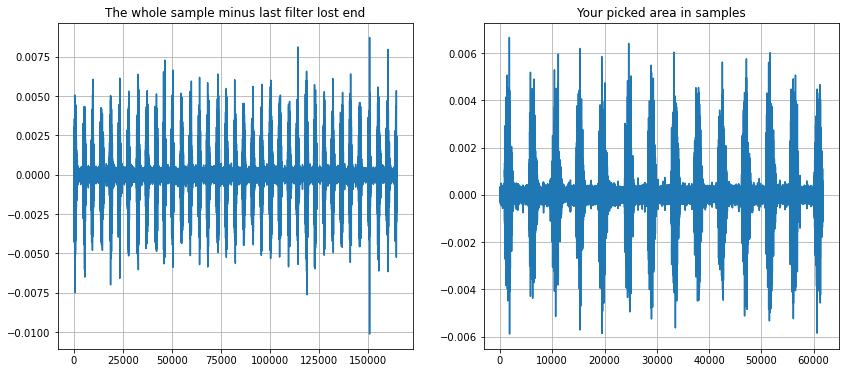

In [35]:
if time_view == 'Seconds':
    %matplotlib inline
    # set up plotn
    x = processed_data_emg
    fig, axis = plt.subplots(nrows = 1, ncols = 2, figsize=(14, 6))
    axis[0].grid(True)
    axis[0].plot(converted_to_seconds[:len(x)], x)
    axis[0].set(title='The whole sample minus last filter lost end')
    axis[1].set(title='Your picked area in seconds')
    axis[1].grid(True)
    axis[1].plot(x[int(start*emg_sample_rate):int(end*emg_sample_rate)])
else:
    %matplotlib inline
    x = processed_data_emg
    fig, axis = plt.subplots(nrows = 1, ncols = 2, figsize=(14, 6))
    axis[0].grid(True)
    axis[0].plot(x)
    axis[0].set(title='The whole sample minus last filter lost end')
    axis[1].set(title='Your picked area in samples')
    axis[1].grid(True)
    axis[1].plot(x[int(start):int(end)])
    

Now we created some basic processed EMG. We will graph it based on the sample selected and the cutoff on entropy. We will ultimately do a cut-off based on something popular in the literature, but let's do one based on one simple parameter first, as an example


In [36]:
# Now we want to select where the cut_off is

entropy_cutoff = widgets.Dropdown(
    options=["Mean","Half_range"],
    value='Mean',
    description="Select Entropy Cut off",
    disabled=False,
)
display(entropy_cutoff)


Dropdown(description='Select Entropy Cut off', options=('Mean', 'Half_range'), value='Mean')

In [37]:
def rounded_for_ent(stralist):
    rounded= np.round_(stralist, decimals = 5)
    return rounded
start_s= start * emg_sample_rate
end_s = end * emg_sample_rate
if time_view == 'Samples':
    big_list = rounded_for_ent(processed_data_emg[int(start):int(end)])# replace with whole array of time series!
else:
   
    big_list = rounded_for_ent(processed_data_emg[int(start_s):int(end_s)])
slice_length = 100
def sliceIterator(lst, sliceLen):
    for i in range(len(lst) - sliceLen + 1):
        yield lst[i:i + sliceLen]
index_hold = []
for slice in sliceIterator(big_list, slice_length):
    entropy_index = hf.entropical(slice)
    index_hold.append(entropy_index)

if entropy_cutoff.value == 'Half_range':
    decision_cutoff = (np.max(index_hold) + np.min(index_hold))/2
else:# entropy_cutoff.value == 'Mean':
    decision_cutoff = np.mean(index_hold)


rms_rolled = hf.vect_naive_rolling_rms(index_hold,100) # so rms is rms entropy

Now let's see how we would have split it on that criteria

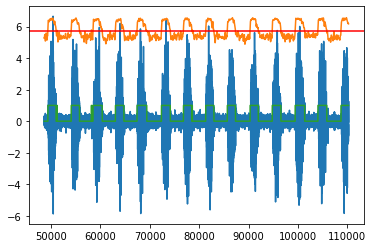

In [38]:
if time_view == 'Samples':
    #y= converted_to_samples
    plt.plot(converted_to_samples[int(start):(int(start) + len(rms_rolled))],processed_data_emg[int(start):(int(start) + len(rms_rolled))]*1000)
    plt.plot(converted_to_samples[int(start):(int(start) + len(rms_rolled))],rms_rolled)
    plt.plot(converted_to_samples[int(start):(int(start) + len(rms_rolled))],hf.zero_one_for_jumps_base(rms_rolled,decision_cutoff))
    plt.axhline(y = decision_cutoff, color = 'r', linestyle = '-')
    
else:
    y = converted_to_seconds
    plt.plot(converted_to_seconds[int(start_s):(int(start_s)+int(len(rms_rolled)))], processed_data_emg[int(start_s):(int(start_s)+len(rms_rolled))]*1000)
    plt.plot(converted_to_seconds[int(start_s):(int(start_s)+int(len(rms_rolled)))],rms_rolled)
    plt.plot(converted_to_seconds[int(start_s):(int(start_s)+int(len(rms_rolled)))],hf.zero_one_for_jumps_base(rms_rolled,decision_cutoff))
    plt.axhline(y = decision_cutoff, color = 'r', linestyle = '-')
    

In the above picture the green line represents a 0,1, array which represents the breaths. That picking was based on one simple parameter.

# Changes here!
Instead of above code we will do
pick breath based on 90% entropy
then 50%- this will give start of breath
define peak value within 90%
moving forward to right 70%-> with smoothing away if there is too short a pause. This is a more complicated algorithm. 

In [39]:
# reminder
time_view

'Samples'

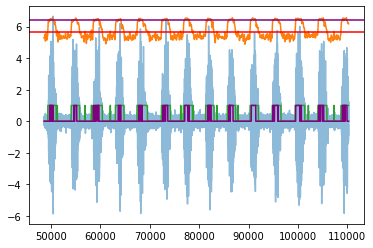

In [40]:

def rounded_for_ent(stralist):
    rounded= np.round_(stralist, decimals = 5)
    return rounded
if time_view == 'Samples':
    big_list = rounded_for_ent(processed_data_emg[int(start):int(end)])# replace with whole array of time series!
else:
    big_list = rounded_for_ent(processed_data_emg[int(start_s):int(end_s)])
slice_length = 100
def sliceIterator(lst, sliceLen):
    for i in range(len(lst) - sliceLen + 1):
        yield lst[i:i + sliceLen]
index_hold = []
for slice in sliceIterator(big_list, slice_length):
    entropy_index = hf.entropical(slice)
    index_hold.append(entropy_index)

high_decision_cutoff = 0.9  * ((np.max(index_hold)) - (np.min(index_hold))) + np.min(index_hold)
decision_cutoff = 0.5 * ((np.max(index_hold)) - (np.min(index_hold))) + np.min(index_hold)

rms_rolled = hf.vect_naive_rolling_rms(index_hold,100) # so rms is rms entropy


if time_view == 'Samples':
    plt.plot(converted_to_samples[int(start):(int(start) + len(rms_rolled))],processed_data_emg[int(start):(int(start) + len(rms_rolled))]*1000, alpha = 0.5)
    plt.plot(converted_to_samples[int(start):(int(start) + len(rms_rolled))],rms_rolled)
    plt.plot(converted_to_samples[int(start):(int(start) + len(rms_rolled))],hf.zero_one_for_jumps_base(rms_rolled,decision_cutoff))
    plt.plot(converted_to_samples[int(start):(int(start) + len(rms_rolled))],hf.zero_one_for_jumps_base(rms_rolled,high_decision_cutoff), color= 'purple')
    plt.axhline(y = decision_cutoff, color = 'r', linestyle = '-')
    plt.axhline(y = high_decision_cutoff, color = 'purple', linestyle = '-')
    
else:
    y = converted_to_seconds
    plt.plot(converted_to_seconds[int(start_s):(int(start_s)+int(len(rms_rolled)))], processed_data_emg[int(start_s):(int(start_s)+len(rms_rolled))]*1000, alpha = 0.5)
    plt.plot(converted_to_seconds[int(start_s):(int(start_s)+int(len(rms_rolled)))],rms_rolled)
    plt.plot(converted_to_seconds[int(start_s):(int(start_s)+int(len(rms_rolled)))],hf.zero_one_for_jumps_base(rms_rolled,decision_cutoff))
    plt.plot(converted_to_seconds[int(start_s):(int(start_s)+int(len(rms_rolled)))],hf.zero_one_for_jumps_base(rms_rolled,high_decision_cutoff), color = 'purple')
    plt.axhline(y = decision_cutoff, color = 'r', linestyle = '-')
    plt.axhline(y = high_decision_cutoff, color = 'purple', linestyle = '-')
    

In [41]:
def merge(left, right):
    # Initialize an empty list output that will be populated with sorted elements.
    # Initialize two variables i and j which are used pointers when iterating through the lists.
    output = []
    i = j = 0

    # Executes the while loop if both pointers i and j are less than the length of the left and right lists
    while i < len(left) and j < len(right):
        # Compare the elements at every position of both lists during each iteration
        if left[i] < right[j]:
            # output is populated with the lesser value
            output.append(left[i])
            # 10. Move pointer to the right
            i += 1
        else:
            output.append(right[j])
            j += 1
    # The remnant elements are picked from the current pointer value to the end of the respective list
    output.extend(left[i:])
    output.extend(right[j:])

    return output

In [42]:


slice = builtins.slice

class Range(namedtuple('RangeBase', 'start,end')):
    
    def intersects(self, other):
        return (
            (self.end >= other.end) and (self.start < other.end) or
            (self.end >= other.start) and (self.start < other.start) or
            (self.end < other.end) and (self.start >= other.start)
        )
    
    def precedes(self, other):
        return self.end < other.start
    
    def to_slice(self):
        return slice(*map(int, self)) # maps whole tuple set
    


def ranges_of(array):
    marks = np.logical_xor(array[1:], array[:-1])
    boundaries = np.hstack((np.zeros(1), np.where(marks != 0)[0], np.zeros(1) + len(array) - 1))

    if not array[0]:
        boundaries = boundaries[1:]
    if len(boundaries) % 2 != 0:
        boundaries = boundaries[:-1]
    return tuple(Range(*boundaries[i:i+2]) for i in range(0, len(boundaries), 2))


def intersections(left, right):
    i, j = 0, 0
    result = []
    while i < len(left) and j < len(right):
        lelt, relt = left[i], right[j]
        if lelt.intersects(relt):
            result.append(lelt)
            i += 1
        elif relt.precedes(lelt):
            j += 1
        elif lelt.precedes(relt):
            i += 1
    return result


hi = np.array(hf.zero_one_for_jumps_base(rms_rolled, high_decision_cutoff))
lo = np.array(hf.zero_one_for_jumps_base(rms_rolled, decision_cutoff))

rhi = ranges_of(hi)
rlo = ranges_of(lo)

keep = intersections(rlo, rhi)


points = np.array(sum(keep, start=()), dtype=np.int32)
points

array([  739,  2413,  5447,  7147,  9857, 11741, 14390, 16129, 18761,
       20866, 23693, 25507, 28130, 29977, 32643, 34322, 37007, 38679,
       41619, 43297, 46097, 47866, 50725, 52675, 55331, 57152, 60000,
       61537])

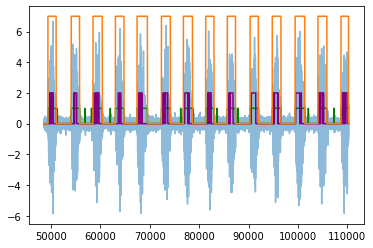

In [43]:
seven_line = np.zeros(len(rms_rolled))
for seven_range in keep:
    seven_line[seven_range.to_slice()] = 7
if time_view == 'Samples':
    plt.plot(converted_to_samples[int(start):(int(start) + len(rms_rolled))],processed_data_emg[int(start):(int(start) + len(rms_rolled))]*1000, alpha = 0.5)
    plt.plot(converted_to_samples[int(start):(int(start) + len(rms_rolled))],hf.zero_one_for_jumps_base(rms_rolled,decision_cutoff),  color = 'green')
    plt.plot(converted_to_samples[int(start):(int(start) + len(rms_rolled))],(np.array(hf.zero_one_for_jumps_base(rms_rolled,high_decision_cutoff)))*2, color= 'purple')
    #plt.plot(converted_to_samples[int(start):(int(start) + len(rms_rolled))], six_line)
    plt.plot(converted_to_samples[int(start):(int(start) + len(rms_rolled))], seven_line)
else:
    plt.plot(converted_to_seconds[int(start_s):(int(start_s) + len(rms_rolled))],processed_data_emg[int(start_s):(int(start_s) + len(rms_rolled))]*1000, alpha = 0.5)
    plt.plot(converted_to_seconds[int(start_s):(int(start_s) + len(rms_rolled))],hf.zero_one_for_jumps_base(rms_rolled,decision_cutoff),  color = 'green')
    plt.plot(converted_to_seconds[int(start_s):(int(start_s) + len(rms_rolled))],(np.array(hf.zero_one_for_jumps_base(rms_rolled,high_decision_cutoff)))*2, color= 'purple')
    #plt.plot(converted_tosecondss[int(star_st):(int(star_st) + len(rms_rolled))], six_line)
    plt.plot(converted_to_seconds[int(start_s):(int(start_s) + len(rms_rolled))], seven_line)
    

So above our 'seven-line' represents picking based on finding areas with 90% max entropy, then picking evything around them with over 50% entropy.

## Split off breath non-breath versus breath chunks
Here we will call inhale and exhale

In [109]:
our_emg_array = processed_data_emg[int(start):(int(start) + len(rms_rolled))]
jump_indeces = []

zippy = zip(seven_line,seven_line[1:])
for val in enumerate(zippy):
    if val[1][0] != val[1][1]:
        #print(val[0])
        jump_indeces.append(val[0])

grouped = np.split(our_emg_array, jump_indeces)
#grouped

In [112]:
inhalers = []
exhalers = []
abs_groups = []
for group in grouped:
    group = abs(group)
    abs_groups.append(group)
    abs_emg_array = abs(our_emg_array)
    if group.mean() < abs_emg_array.mean():
        exhalers.append(group)
    else:
        inhalers.append(group)
    


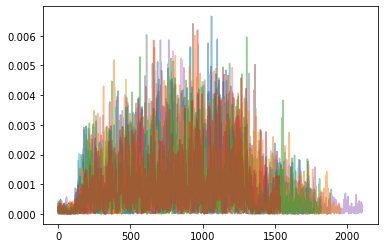

In [113]:
for inhale in inhalers:
    plt.plot(inhale, alpha =0.5)
    

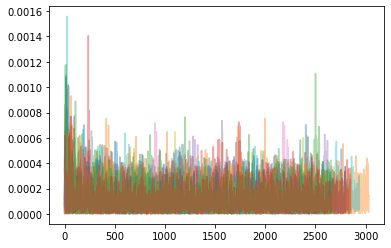

In [114]:
for exhale in exhalers:
    plt.plot(exhale, alpha = 0.4)

In [115]:
output_path1 = 'ML_files/high/'
output_path2 = 'ML_files/low/'
isExist1 = os.path.exists(output_path1)
isExist2 = os.path.exists(output_path2)
if not isExist1:
    os.makedirs(output_path1)
    print("The new directory for the processed stacked arrays is created at folder:", output_path1)
else:
    print("Output files will be sent to the folder named:", output_path1)
if not isExist2:
    os.makedirs(output_path2)
    print("The new directory for the processed stacked arrays is created at folder:", output_path2)
else:
    print("Output files will be sent to the folder named:", output_path2)

Output files will be sent to the folder named: ML_files/high/
Output files will be sent to the folder named: ML_files/low/


In [116]:
n=0
for inhale in inhalers:
    filename = file_chosen
    stripped_filename = filename.replace("\\", "")
    stripped_filename = stripped_filename .replace('../', '')
    stripped_filename = stripped_filename.replace('.Poly5', '')
    stripped_filename = stripped_filename + str(n)
    #print(os.path.join(output_path1, stripped_filename))
    n+= 1
    file = open(os.path.join(output_path1, stripped_filename), "wb")
## save array to the file
    np.save(file, inhale)
## close the file
    file.close

In [117]:
n=0
for exhale in exhalers:
    filename = file_chosen
    stripped_filename = filename.replace("\\", "")
    stripped_filename = stripped_filename .replace('../', '')
    stripped_filename = stripped_filename.replace('.Poly5', '')
    stripped_filename = stripped_filename + str(n)
    #new_output_path = 'ML_files/inhales'
    #print(os.path.join(output_path1, stripped_filename))
    n+= 1
    file = open(os.path.join(output_path2, stripped_filename), "wb")
## save array to the file
    np.save(file, exhale)
## close the file
    file.close

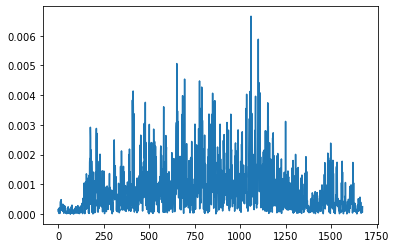

In [119]:
shower = np.load('ML_files/high/not_pushedtopspin_data_anonymizedM001001EMG_recording0')
plt.plot(shower)

In [ ]:
Then we want to load everything into a labeled dataset: 

In [217]:
data= []
label = []
for inhale in inhalers:
    data.append(inhale)
    #label.append('inhale')

    #label.append('exhale')

In [218]:
for_mli = pd.DataFrame(data)

In [219]:
for_mli['label'] = 'inhlae'

In [267]:
data= []
label = []
# cutter = 1000
for exhale in exhalers:
    data.append(exhale)
#     if len(exhale) < cutter:
#         cutter = len(exhale)
    


In [268]:
for_mle = pd.DataFrame(data)


In [275]:

listicle = list(range(0, 1000))
new_exhales = for_mle[listicle].copy()
new_exhales['label'] = 'exhale'
new_inhales = for_mli[listicle].copy()
new_inhales['label'] = 'inhale'

In [276]:
new_inhales.head()

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,label
0,0.000145,0.000072,0.000073,0.000174,0.000138,0.000016,0.000173,0.000210,0.000117,0.000019,...,0.000275,0.001376,0.001199,0.000209,0.000427,0.000198,0.000526,0.000566,0.000115,inhale
1,0.000095,0.000031,0.000011,0.000009,0.000041,0.000175,0.000284,0.000165,0.000124,0.000280,...,0.000429,0.002020,0.000173,0.000828,0.001163,0.000908,0.001420,0.000826,0.001830,inhale
2,0.000423,0.000308,0.000032,0.000223,0.000150,0.000029,0.000032,0.000082,0.000057,0.000026,...,0.000084,0.000990,0.000853,0.000635,0.000702,0.000162,0.000235,0.000716,0.000153,inhale
3,0.000152,0.000031,0.000022,0.000063,0.000221,0.000092,0.000076,0.000059,0.000078,0.000105,...,0.001823,0.001018,0.002009,0.003212,0.002127,0.000282,0.002569,0.001300,0.000617,inhale
4,0.000262,0.000143,0.000113,0.000342,0.000355,0.000149,0.000126,0.000323,0.000331,0.000130,...,0.000776,0.000296,0.000500,0.000144,0.000451,0.002373,0.000788,0.001831,0.002422,inhale


In [277]:
for_ml_together = pd.concat([new_exhales,new_inhales])

In [279]:
#for_ml=for_ml['index'].drop()
for_ml_together.tail()

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,label
9,0.000047,0.000268,0.000034,0.000122,0.000095,0.000003,0.000061,0.000061,0.000031,0.000023,...,0.002202,0.002860,0.002644,0.001030,0.001709,0.004113,0.004459,0.002320,0.000903,inhale
10,0.000235,0.000052,0.000084,0.000047,0.000074,0.000154,0.000111,0.000072,0.000262,0.000254,...,0.000245,0.000133,0.001269,0.000313,0.000649,0.000745,0.000089,0.000689,0.000788,inhale
11,0.000047,0.000183,0.000252,0.000116,0.000048,0.000111,0.000136,0.000181,0.000175,0.000047,...,0.001464,0.000478,0.000724,0.002341,0.003248,0.001760,0.002077,0.002072,0.000567,inhale
12,0.000205,0.000069,0.000143,0.000055,0.000019,0.000100,0.000159,0.000132,0.000100,0.000058,...,0.001063,0.000025,0.000250,0.000663,0.000164,0.000244,0.000284,0.000630,0.000812,inhale
13,0.000351,0.000207,0.000085,0.000338,0.000383,0.000201,0.000069,0.000255,0.000249,0.000067,...,0.000496,0.003859,0.001860,0.004040,0.000773,0.003995,0.000527,0.001733,0.000462,inhale


In [280]:
for_ml_together.to_csv('ML_files/for_ml_csv.csv')

So we can rereun to do more and more inhales and exhales, and load them up with seperate names into folders, and we need to rewrite out dataset  sheet

Now we need to figure out which elements of grouped are breath parts, and make arrays of just those.

In [ ]:
big_data_list.append(data_now)
big_data_list

In [ ]:
columns_now = ['file_chosen',
               'number_file',
               'units',
               'start_cut',
               'end_cut',
               'my_hand_count',
               'automated_breath_count',
               'maxima',
               'maxima_values',
               'curve_area_under',
               'curve_area_under_entropy',
               ]

df = pd.DataFrame(big_data_list, columns=columns_now)

In [ ]:
df

In [ ]:
#You probably want to change the name to a timestamp, and save every hour, at least. 
df.to_csv('my_saved_entropy_experiments.csv')